In [1]:
from fastai.text import *
import pandas as pd

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!ls

README.md  YelpChi.ipynb  data


In [4]:
path = 'data/Yelp/'
df_meta = pd.read_csv(path+'output_meta_yelpResData_NRYRcleaned.txt', sep=' ', header=None)

df_meta.head(3)


,0,1,2,3,4,5,6,7,8
0,9/22/2012,GtwU21YOQn-wf4vWRUIx6w,bNYesZ944s6IJVowOnB0iA,pbEiXam9YJL3neCYHGwLUA,N,0,0,0,5
1,9/22/2012,0LpVTc3,TRKxLC3y-ZvP45e5iilMtw,pbEiXam9YJL3neCYHGwLUA,N,0,0,0,5
2,9/19/2012,tljtLzf68Fkwf,0EMm8umAqXZzyhxNpL4M9g,pbEiXam9YJL3neCYHGwLUA,N,0,0,2,3


In [5]:
df_reviews = pd.read_csv(path+'output_review_yelpResData_NRYRcleaned.txt', sep='\r', header=None)
df_reviews.head(3)


,0
0,"Unlike Next, which we'd eaten at the previous ..."
1,Probably one of the best meals I've had ever. ...
2,Service was impeccable. Experience and present...


In [6]:
df = pd.merge(df_meta, df_reviews, left_index=True, right_index=True)
df = df.rename(columns={'0_x': 'date', 1: 'id', 2: 'id2', 3: 'id3', 4:'label', '0_y': 'text'})
df = df[['label', 'text']]

In [7]:
df.head(3)

,label,text
0,N,"Unlike Next, which we'd eaten at the previous ..."
1,N,Probably one of the best meals I've had ever. ...
2,N,Service was impeccable. Experience and present...


## Language model

In [ ]:
#data_lm = TextLMDataBunch.from_df(path=path, 
#                                  train_df=df,
#                                  valid_df=df,
#                                  label_cols='label',
#                                  text_cols='text')

bs = 48
data_lm = (TextList.from_df(df, path, cols='text')
         .split_by_rand_pct(0.1)
         .label_for_lm()
         .databunch(bs=bs))

In [ ]:
data_lm.save('YelpChi_lm.pkl')

In [ ]:
data_lm = load_data(path, 'YelpChi_lm.pkl', bs=bs)

In [11]:
data_lm.show_batch()

idx,text
0,"let me know this was a restaurant like no other , a place where there were no rules that had to be followed , a sanctuary which allowed a chef freedom to go wherever imagination led . xxmaj for example , while the beverage choices were explained , six bowls containing blocks of ice resting on xxunk of xxunk were placed on the table , without a word being said"
1,"think it was $ 25 and it 's cash only ) for a pick up order but it 's worth it and it 's easily met with 2 people . i only say this because it is has been slammed each time i 've been there . xxmaj when i went in to pick up my order , the person taking money and orders ( i think it was xxmaj"
2,needs to be said . xxbos xxmaj best xxmaj hot dog place i found in xxmaj chicago so far . xxmaj very proud and xxmaj artsy place . xxmaj you can even et xxunk . xxmaj always be prepared for a 45 minute line outside of the place if there is nt one that s not normal . xxmaj they have xxunk i never heard of in my life .
3,"sense . i bite into this chicken and it sure is heavenly ! xxmaj the 2 more stars . xxmaj now the crisp chicken tenders .. you can pass on them . xxmaj it was a nice attempt for spice , but i am a spice junky . xxmaj so it did not make the cut hence the minus 1 star . xxmaj would i order these again , absolutely"
4,"vibe that has been preserved through the decor . xxmaj if you 're doing poetry night , come by 6:30 to snatch yourself a seat ! xxmaj only reason this place got 4 instead of 5 stars is the seating issue sometimes . xxbos xxmaj wow . xxmaj if you like xxmaj jazz , history , lounges or any of the above i would highly recommend you visit the xxmaj"


In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [13]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


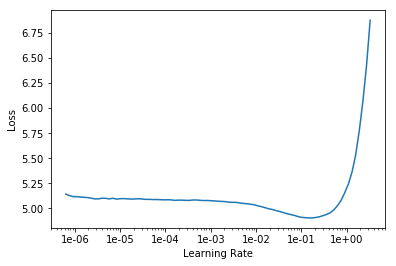

In [14]:
#learn.recorder.plot(skip_end=15)
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.774305,3.665466,0.308299,10:23


In [ ]:
learn.save('fit_head')

In [ ]:
learn.load('fit_head');

In [ ]:
learn.unfreeze()

In [19]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.518165,3.485430,0.329395,12:35
1,3.432258,3.395076,0.341510,12:35
2,3.345852,3.341369,0.348061,12:37
3,3.285008,3.303076,0.353173,12:36
4,3.194479,3.284487,0.356112,12:36


Buffered data was truncated after reaching the output size limit.

In [ ]:
learn.save('fine_tuned')

In [ ]:
learn.load('fine_tuned');

In [22]:
TEXT = "I do not liked this restaurant because"
N_WORDS = 40
N_SENTENCES = 2
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.76) for _ in range(N_SENTENCES)))

I do not liked this restaurant because i love the food here . If you want a great experience and want to take advantage of the restaurant , then i do nt think i would go here again . The food is ok , but
I do not liked this restaurant because it is really small inside . The food is not good and lots of children . The service is subpar . i have been there twice already . My friend was sick of waiting 2 hours to


In [ ]:
learn.save_encoder('fine_tuned_enc')

## Classifier

In [64]:
df = df[['text', 'label']]
df.head(3)

,text,label
0,"Unlike Next, which we'd eaten at the previous ...",N
1,Probably one of the best meals I've had ever. ...,N
2,Service was impeccable. Experience and present...,N


In [ ]:
data_clas = (TextList.from_df(df, path, cols=['text', 'label'], vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_rand_pct(0.1)
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_df(cols='label')
             #label them all with their folders
             .databunch(bs=bs))

#data_clas.save(path, 'data_clas.pkl')
#data_clas

In [90]:
#data_clas.save('models/data_clas.pkl')


FileNotFoundError: ignored

In [91]:
data_clas.show_batch()

text,target
"xxbos i honestly hate this place . xxmaj let me preface this by saying ... i love beer . i love xxmaj belgian beer . i love the beers on their beer menu . i like food . i love going out to eat . i live in the city , and love the area where xxmaj hopleaf is located xxrep 4 . but i hate this place . i",N
"xxbos i 've been here twice , because i felt that there might be opening jitters ... there were n't and there still are n't . i think most of you on here know i have a slight southside bias , so when i am raving this much about a place up north you xxup know it 's good . xxup real xxup good . xxmaj as in , """,N
"xxbos xxmaj utterly fantastic . xxmaj we did the 9 course tasting menu . xxmaj they threw in three extra tastes , so we ended with 12 courses for $ 110 / person . xxup byob , no corkage fee . xxmaj we brought a half bottle of xxunk and a bottles of xxmaj vouvray and xxmaj pinot xxmaj noir . xxmaj atmosphere : xxmaj it is really just a",N
"xxbos xxmaj taking advantage of xxmaj restaurant xxmaj week 2011 , i decided it would be nice to try a new restaurant in the xxmaj gold xxmaj coast for once ( one can only eat at xxmaj hub 51 and xxmaj sushi xxmaj samba so much ) . xxmaj with my love of bbq and being skeptical of any place selling it that is n't named xxmaj smoque , i",N
"xxbos xxmaj once again , it 's time for the "" xxmaj fat xxmaj american xxmaj ca n't xxmaj figure xxmaj out xxmaj foreign xxmaj cuisines "" show ! xxmaj today , we 're returning to xxmaj greece - the xxmaj island regions in particular , because i 've just been to the xxmaj greek xxmaj islands xxmaj restaurant for a lovely dinner ! i had a relative from back",N


In [96]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)
len(data_clas.vocab.itos) == len(data_lm.vocab.itos)

FileNotFoundError: ignored

In [ ]:
#import os
#os.chdir("/content/drive/My Drive/Dissertation")

In [92]:
#!pwd

/content/drive/My Drive/Dissertation


In [95]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

FileNotFoundError: ignored

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()